In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank, inv
from pprint import pprint
from scipy.linalg import null_space
import sys
import os
current_notebook_dir = os.getcwd()
# Replace with the path to your IT_PI.py function
project_root_dir = os.path.join(current_notebook_dir, '..', '..')
it_pi_module_dir = project_root_dir
sys.path.append(it_pi_module_dir)
import IT_PI
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering/', VIEW.as_view(), name=''),

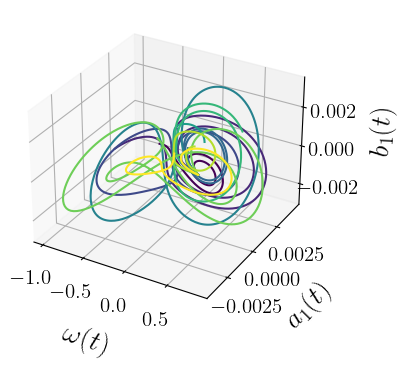

In [2]:
## generate the synthetic data for the chaotic Malkus water wheel system
seed  = 42
np.random.seed(seed)  # Set the seed
pi = np.pi
g = 9.81  # Gravitational acceleration (m / s^2)
r_range = (0.3, 0.7)       # Range for radius of the wheel (m)
q1_range = (0.0001, 0.0005)  # Range for water inflow rate (m^3 / s)
I_range = (0.05, 0.2)      # Range for moment of inertia (kg * m^2)
nu_range = (0.01, 0.1)     # Range for viscous damping coefficient (kg / m / s)
K_range = (0.01, 0.1)      # Range for water leakage rate (1 / s)

# Number of values to generate
num_values = 100  
r_values = np.random.uniform(r_range[0], r_range[1], num_values)
q1_values = np.random.uniform(q1_range[0], q1_range[1], num_values)
I_values = np.random.uniform(I_range[0], I_range[1], num_values)
nu_values = np.random.uniform(nu_range[0], nu_range[1], num_values)
K_values = np.random.uniform(K_range[0], K_range[1], num_values)

# Define the chaotic wheel system ODEs
def chaotic_wheel_system(t, y, r, q_1, I, nu, K):
    omega, a_1, b_1 = y
    dydt = [
        (pi * r * g / I) * a_1 - (nu / I) * omega,  # d(omega)/dt
        omega * b_1 - K * a_1,                      # d(a_1)/dt
        q_1 - K * b_1 - omega * a_1                 # d(b_1)/dt
    ]
    return dydt

# Initial conditions
omega_0 = 0.3   # initial angular velocity
a_1_0 = 0.00001 # initial a_1
b_1_0 = 0.00001 # initial b_1
y0 = [omega_0, a_1_0, b_1_0]

# Time span for the simulation
t_span = (0, 50)  # simulate from t=0 to t=10
t_eval = np.linspace(0,50, 500)
colors = plt.cm.viridis(np.linspace(0, 1, 10))
fig = plt.figure(figsize=(4, 4))
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['text.usetex'] = True  
ax = fig.add_subplot(111, projection='3d')
solutions = []
p = []   
dq = []  
for i, (r, q_1, I, nu, K) in enumerate(zip(r_values, q1_values, I_values, nu_values, K_values)):
    sol = solve_ivp(chaotic_wheel_system, t_span, y0, t_eval=t_eval, args=(r, q_1, I, nu, K))
    solutions.append(sol)  
    p.extend(np.column_stack(( [[r, q_1, I, nu, K , g]] * len(sol.t),sol.y[0], sol.y[1], sol.y[2],  )))  # Store [omega(t), a_1(t), b_1(t)]

    for omega, a_1, b_1 in zip(sol.y[0], sol.y[1], sol.y[2]):
        dq.append([
            ((pi * r * g / I) * a_1 - (nu / I) * omega),  # d(omega)/dt
            omega * b_1 - K * a_1,                      # d(a_1)/dt
            q_1 - K * b_1 - omega * a_1                 # d(b_1)/dt
        ])
    if i < 10:
        ax.plot(sol.y[0], sol.y[1], sol.y[2], label=f'r={r:.2f}, q_1={q_1:.6f}, I={I:.2f}, nu={nu:.2f}, K={K:.2f}', color=colors[i])
ax.xaxis.set_tick_params(width=1, labelsize=15, pad = 5)
ax.yaxis.set_tick_params(width=1, labelsize=15, pad = 5)
ax.zaxis.set_tick_params(width=1, labelsize=15, pad = 5)
ax.set_xlabel('$\omega(t)$', fontsize=20, labelpad=15)
ax.set_ylabel('$a_1(t)$', fontsize=20, labelpad=15)
ax.set_zlabel('$b_1(t)$', fontsize=20, labelpad=15)
plt.show()


In [3]:
p  = np.array(p)   
dq = np.array(dq)
dq = dq[:,0].reshape(-1,1)
r     = p[:,0].reshape(-1,1)
q1    = p[:,1].reshape(-1,1)
I     = p[:,2].reshape(-1,1)
nu    = p[:,3].reshape(-1,1)
K     = p[:,4].reshape(-1,1)
p = p / p.max(axis=0)

dq  = dq/ K**2
#dq  = dq/(nu/I)**2
# Print out shapes for verification
print(f"Shape of p: {p.shape}")
print(f"Shape of dq (dw_1): {dq.shape}")


valid_rows = np.all(p >= 0, axis=1)
# Filter out the invalid rows from p and dq
p_filtered = p[valid_rows]
dq_filtered = dq[valid_rows]
# Output the filtered results
print('Filtered p:', p_filtered.shape)
print('Filtered dq:', dq_filtered.shape)

Shape of p: (50000, 9)
Shape of dq (dw_1): (50000, 1)
Filtered p: (28979, 9)
Filtered dq: (28979, 1)


In [4]:
D_in = np.matrix(' 1 0 2 2 0 1 0 0 0;  0 -1 0 -1 -1 -2 -1 0 0 ; 0 1 1 1 0 0 0 1 1 ')
print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows   = np.shape(D_in)[0]
num_cols   = np.shape(D_in)[1]
# Function to calculate basis matrices
num_basis = D_in.shape[1] - matrix_rank(D_in)
basis_matrices = IT_PI.calc_basis(D_in,num_basis)
basis_matrices[3:6,:] = -basis_matrices[3:6,:]
print("Basis vectors from null space:")
print(basis_matrices)
num_input  = 2
X = p_filtered
Y = dq_filtered

Rank of D_in: 3
D_in matrix:
 [[ 1  0  2  2  0  1  0  0  0]
 [ 0 -1  0 -1 -1 -2 -1  0  0]
 [ 0  1  1  1  0  0  0  1  1]]
Basis vectors from null space:
[[ 2.  1.  0. -1.  0.  0.  0.  0.  0.]
 [ 2.  1. -1.  0. -1.  0.  0.  0.  0.]
 [ 5.  2. -2.  0.  0. -1.  0.  0.  0.]
 [-2. -1.  1. -0. -0. -0.  1. -0. -0.]
 [ 2. -0. -1. -0. -0. -0. -0.  1. -0.]
 [ 2. -0. -1. -0. -0. -0. -0. -0.  1.]]


In [5]:
# Run dimensionless learning
results = IT_PI.main(
    X,
    Y,
    basis_matrices,
    num_input=num_input,
    estimator="binning",
    estimator_params={"num_bins": 60},
    maxiter= 200,
    seed=42
)


input_PI = results["input_PI"]
epsilon  = results["irreducible_error"]
uq       = results["uncertainty"]

------------------------------------------------------------
num of parameters: 12

Using estimator: 'binning' with hyperparameters: {'num_bins': 60}

(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 12 (seed=42, Mon Sep  8 13:59:36 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 -5.456697734567539e-01 1.0e+00 5.85e-01  5e-01  6e-01 0:04.0
    2    600 -5.224452544473870e-01 1.5e+00 7.24e-01  5e-01  8e-01 0:08.2
    3    900 -5.583542165091355e-01 2.0e+00 8.39e-01  6e-01  9e-01 0:12.4
    4   1200 -5.889405022133936e-01 2.4e+00 8.86e-01  5e-01  1e+00 0:16.5
    5   1500 -5.868660095117204e-01 2.7e+00 9.96e-01  5e-01  1e+00 0:20.7
    7   2100 -6.136399660916432e-01 3.9e+00 1.01e+00  4e-01  1e+00 0:29.1
    9   2700 -6.425902933509375e-01 5.0e+00 1.00e+00  4e-01  8e-01 0:37.4
   11   3300 -6.738669962230297e-01 5.9e+00 1.06e+00  3e-01  8e-01 0:46.0
   13   3900 -7.187527361098960e-01 8.0e+00 1.03e+00  3e-01  7e-01 0:54.4
   16   4800 -7.3903

In [6]:
import copy
coef_pi_list = copy.deepcopy(results.get("input_coef", []))
#swap the first and the second in list
coef_pi_list[0], coef_pi_list[1] = coef_pi_list[1], coef_pi_list[0]
#  time each element in coef_pi_list with 2 and round to the integer, in the list there is an array
normalized_coef_pi_list = [
    np.round(-2 * np.array(pi).reshape(1, -1)).astype(int) for pi in coef_pi_list
]

variables        = ['r','q_1','I','\\nu','K','g', '\\omega(t)','m_1(t)' , 'm_2(t)'];                   #Define variable name
optimal_pi_lab   = IT_PI.create_labels(np.array(normalized_coef_pi_list).reshape(-1, len(variables)), variables)
for j, label in enumerate(optimal_pi_lab):
    print(f'Optimal_pi_lab[{j}] = {label}')


Optimal_pi_lab[0] = $\frac{I^{1.0} \cdot K^{2.0}}{r^{1.0} \cdot g^{1.0} \cdot m_1(t)^{1.0}}$
Optimal_pi_lab[1] = $\frac{I^{1.0} \cdot K^{2.0}}{\nu^{1.0} \cdot \omega(t)^{1.0}}$


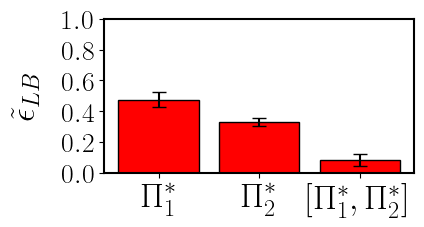

Irreducible error: [0.4754803364719441, 0.32858393656870194, 0.08226983806762572]


In [7]:
# Plotting the results
x_labels = [r'$\Pi_1^*$', r'$\Pi_2^*$', r"$[\Pi_1^*,\Pi_2^*]$"]
plt.figure(figsize=(4, 2))
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Use uq_values as the error bars
plt.bar(x_labels, epsilon, yerr=uq, capsize=5, edgecolor='black',color = 'red')
plt.xticks(fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel(r'$\tilde{\epsilon}_{L B}$', fontsize=25, labelpad=15)
plt.ylim([0, 1])
plt.savefig('Malkus_rank.eps', dpi=300, bbox_inches='tight',transparent=True)
plt.show()

print("Irreducible error:", epsilon)

In [8]:
## Calculate the characteristic length scale for each variable
from scipy.optimize import minimize
from numpy.linalg import lstsq
from IPython.display import display, Math

def solve_and_check_residuals(gamma_matrix, rhs_matrix, D_qp):
    """
    Solve min ||gamma_matrix @ C_solution - rhs_matrix||_2^2 
    with additional penalty term enforcing D_qp @ C_solution^T = I.
    """
    # Get matrix dimensions
    num_vars = gamma_matrix.shape[1]  # Number of unknowns in C_solution
    num_outputs = rhs_matrix.shape[1]  # Number of columns in C_solution
    num_constraints = D_qp.shape[0]  # Number of constraints
    # Solve the unconstrained least squares problem as the initial guess
    C_solution_init, _, _, _ = lstsq(gamma_matrix, rhs_matrix, rcond=None)

    # Define loss function: Least squares + constraint penalty
    def loss(C_solution_flat):
        C_solution = C_solution_flat.reshape(num_vars, num_outputs)  # Reshape into matrix form
        lsq_term = np.linalg.norm(gamma_matrix @ C_solution - rhs_matrix, ord=2) ** 2  # Original least squares
        constraint_violation = np.linalg.norm(D_qp @ C_solution.T - np.eye(num_constraints), ord=2) ** 2  # Enforce constraint
        return lsq_term +  constraint_violation  # Add weighted penalty

    # Solve using scipy's minimize function
    result = minimize(
        loss, C_solution_init.flatten(), method="L-BFGS-B", options={"maxiter": 1000}
    )

    # Extract optimized solution in matrix form
    C_solution_opt = result.x.reshape(num_vars, num_outputs)

    # Compute residuals
    residual_check = np.dot(gamma_matrix, C_solution_opt) - rhs_matrix
    residual_check = np.round(residual_check, 1)

    return C_solution_opt, residual_check


# Function to print LaTeX labels
def print_c_latex_labels(C_solution, variables_c):
    c_labels = IT_PI.create_labels(np.round(C_solution, 1), variables_c)
    labels = ['t_c', 'm_c']
    for j, label in enumerate(c_labels):
        print(f'{labels[j]} =')
        display(Math(label))
# Function to print LaTeX labels
def print_r_latex_labels(residual_check, variables_c):
    r_labels = IT_PI.create_labels(np.round(residual_check, 1), variables_c)
    for j, label in enumerate(r_labels):
        print(f'Pi_lab[{j}]=') 
        display(Math( label ))
def normalize_residual_rows(residual_matrix):
    normalized_residual = np.zeros_like(residual_matrix)
    for i in range(residual_matrix.shape[0]):
        max_val = np.max(np.abs(residual_matrix[i]))  # Find the largest absolute value in the row
        if max_val != 0:  # Avoid division by zero
            normalized_residual[i] = residual_matrix[i] / max_val
    return normalized_residual
        
# Initialize empty lists for gamma and RHS matrices
gamma_matrix = []
rhs_matrix = []
D_qp = D_in[1:, :6]
num_p = 6
# For each Pi group, extract gamma and the RHS and store them in the matrices
for i, normalized_coef_pi in enumerate(normalized_coef_pi_list):
    gamma = (D_in[:, num_p:] * (normalized_coef_pi[:,num_p:].T)) 
    gamma_matrix.append(np.array(gamma).flatten()) 
    rhs   = -np.array(normalized_coef_pi[:,:num_p])
    rhs_matrix.append(np.array(rhs))
##Non-dimensional output \Pi_o
gamma_matrix.append(np.array([0, -2, 0]))
rhs_matrix.append(np.array([0, 0, 0, 0, 2, 0]))

gamma_matrix = np.array(gamma_matrix)
rhs_matrix   = np.vstack(rhs_matrix)
print('rhs_matrix', rhs_matrix)

# Find columns that are entirely zero
non_zero_columns        = np.any(gamma_matrix != 0, axis=0)
filtered_gamma_matrix   = gamma_matrix[:, non_zero_columns]
print('filtered_gamma_matrix', filtered_gamma_matrix)

rhs_matrix_o            = rhs_matrix
filtered_gamma_matrix_o = filtered_gamma_matrix
# Iteratively remove rows with large residuals
while True:
    C_solution, residual_check = solve_and_check_residuals(filtered_gamma_matrix, rhs_matrix,D_qp)
    print('Current residuals = \n', residual_check)
    
    # Find rows with residuals larger than 1e-3
    large_residuals = np.abs(residual_check) > 1e-2
    rows_with_large_residuals = np.where(np.any(large_residuals, axis=1))[0]
    
    if len(rows_with_large_residuals) == 0:
        # No significant residuals remain, break the loop
        print("No residuals larger than 1e-3 found. Solution is stable.")
        break
    row_to_remove = np.random.choice(rows_with_large_residuals)
    filtered_gamma_matrix = np.delete(filtered_gamma_matrix, row_to_remove, axis=0)
    rhs_matrix = np.delete(rhs_matrix, row_to_remove, axis=0)
    
print("Final solution:")
print(C_solution)
variables_c = ['r', 'q_1', 'I', '\\nu', 'K', 'g']
print_c_latex_labels(C_solution, variables_c)

residual_check            = np.dot(filtered_gamma_matrix_o, C_solution) - rhs_matrix_o
non_zero_rows             = np.any(residual_check != 0, axis=1)
filtered_residual_check   = residual_check[non_zero_rows,:]
normalized_final_residual = normalize_residual_rows(filtered_residual_check)
print("Final residual:",normalized_final_residual)
print_r_latex_labels(normalized_final_residual, variables_c)


rhs_matrix [[ 1  0 -1  0 -2  1]
 [ 0  0 -1  1 -2  0]
 [ 0  0  0  0  2  0]]
filtered_gamma_matrix [[ 0 -1]
 [ 1  0]
 [-2  0]]
Current residuals = 
 [[ 0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.8 -0.8  0.8  0. ]
 [ 0.   0.   0.4 -0.4  0.4  0. ]]
Current residuals = 
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
No residuals larger than 1e-3 found. Solution is stable.
Final solution:
[[ 0.  0.  0.  0. -1.  0.]
 [-1.  0.  1.  0.  2. -1.]]
t_c =


<IPython.core.display.Math object>

m_c =


<IPython.core.display.Math object>

Final residual: [[ 0.  0.  1. -1.  1.  0.]]
Pi_lab[0]=


<IPython.core.display.Math object>

In [9]:
import pickle

workspace = {}
globals_copy = dict(globals())

for key, value in globals_copy.items():
    if not key.startswith('_') and not callable(value) and not hasattr(value, '__module__'):
        try:
            pickle.dumps(value)  # Test if it can be pickled
            workspace[key] = value
        except (TypeError, AttributeError):
            print(f"Skipping {key} - cannot pickle")

with open('output.pkl', 'wb') as f:
    pickle.dump(workspace, f)

Skipping np - cannot pickle
Skipping plt - cannot pickle
Skipping sys - cannot pickle
Skipping os - cannot pickle
Skipping IT_PI - cannot pickle
Skipping copy - cannot pickle
Skipping pickle - cannot pickle
